In [ ]:
import aiohttp
import asyncio
from astropy.io import fits
from scipy.interpolate import interp1d
import numpy as np
from io import BytesIO

In [ ]:

# Downloads and processes a fits file.
async def download_and_process_file(session, plate, mjd, fiberID, type, redshift, w):
    for i in range (len(plate), 4):
        plate = "0" + plate
    for i in range (len(fiberID), 4):
        fiberID = "0" + fiberID

    file_url = f"https://dr18.sdss.org/sas/dr18/spectro/sdss/redux/26/spectra/{plate}/spec-{plate}-{mjd}-{fiberID}.fits"
    # Attempt to download a fits file.
    async with session.get(file_url) as response:
        if response.status == 200:
            content = await response.read()
            hdul = fits.open(BytesIO(content))
            flux = hdul[1].data['flux']

             # Wavelength is on a log scale; convert to linear scale
            wavelength = 10**hdul[1].data['loglam']

            common_wavelengths = np.arange(3800, 9200, 10)
            # The commented-out line attempts to bin the fluxes.
            # This reduces the feature set size, at the cost of removing information about line amplitudes and widths.
            # aligned_fluxes = align_spectrum(wavelength, flux, common_wavelengths)
            aligned_fluxes = np.pad(flux, (0, 3900 - len(flux)), 'constant')
            write_fluxes(aligned_fluxes, type, redshift, w)
            return 0
        else:
            return 1


In [ ]:
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter1d

def align_spectrum(wavelengths, fluxes, common_wavelengths, smoothing_sigma=3):
    """
    Aligns the spectrum to common wavelengths.

    Parameters:
    - wavelengths: Original wavelengths of the spectrum
    - fluxes: Original fluxes of the spectrum
    - common_wavelengths: Target wavelengths to align to
    - smoothing_sigma: Standard deviation for Gaussian smoothing. Default is 1.0.
                       Set to 0 or None to skip smoothing.

    Returns:
    - aligned_fluxes: Fluxes aligned to the common wavelengths
    """
    # Apply Gaussian smoothing if required
    if smoothing_sigma and smoothing_sigma > 0:
        fluxes = gaussian_filter1d(fluxes, sigma=smoothing_sigma)

    # Create the interpolator
    interpolator = interp1d(wavelengths, fluxes, kind='linear', bounds_error=False, fill_value=0)

    # Interpolate to the common wavelengths
    aligned_fluxes = interpolator(common_wavelengths)

    return aligned_fluxes


In [ ]:

def write_fluxes(fluxes, type, redshift, w):
    for i in range(len(fluxes)):
        w.write(f"{round(fluxes[i], 2)},")
    for i in range(100):
        w.write(f"{redshift},")
    w.write(f"{type}\n")

In [ ]:
# Main code. Attempts to process all FITS files.
async def main():
    f = open("data.csv", "r")
    w = open("training.txt", "w")
    f.readline()

    for i in range(1, 3901):
        w.write(f"{i},")
    for i in range(100):
      w.write(f"redshift{i},")
    w.write("type\n")
    # Creates a async session
    async with aiohttp.ClientSession() as session:
        tasks = []
        for line in f:
            words = line.split(",")
            plate = words[30]
            mjd = words[31]
            fiberID = words[32]
            obj_type = words[14]
            redshift = words[13]
            train_type = ""

            if "Q" in obj_type:
                train_type = "Quasar"
                task = download_and_process_file(session, plate, mjd, fiberID, train_type, redshift, w)
                tasks.append(task)
            elif (obj_type == "S1" or obj_type == "S1n" or obj_type == "S1.5"):
                train_type = "Seyfert 1"
                task = download_and_process_file(session, plate, mjd, fiberID, train_type, redshift, w)
                tasks.append(task)
            elif (obj_type == "S1.8" or obj_type == "S1.9" or obj_type == "S2"):
                train_type = "Seyfert 2"
                task = download_and_process_file(session, plate, mjd, fiberID, train_type, redshift, w)
                tasks.append(task)


        # Attempt to process as many tasks as possible at the same time.
        error_counts = await asyncio.gather(*tasks)
        print(f"Total errors: {sum(error_counts)}")

    w.close()
    f.close()

In [ ]:
await main()

Total errors: 2019


# kNN Algorithm

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns  # This provides a nicer visual representation
from sklearn.metrics import ConfusionMatrixDisplay

def plot_confusion_matrix(cm, classes):
    """Plots a confusion matrix."""
    fig, ax = plt.subplots(figsize=(7,7))

    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False,
                xticklabels=classes, yticklabels=classes)

    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show()



(2628, 4001)
(2628, 4000)
(2628,)


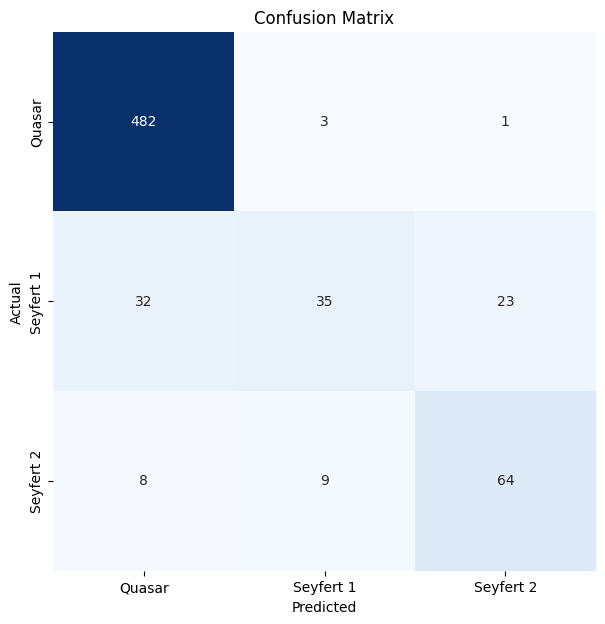

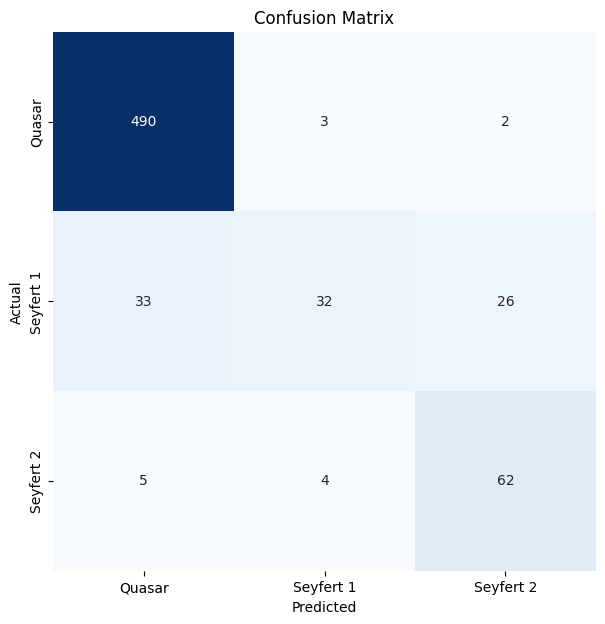

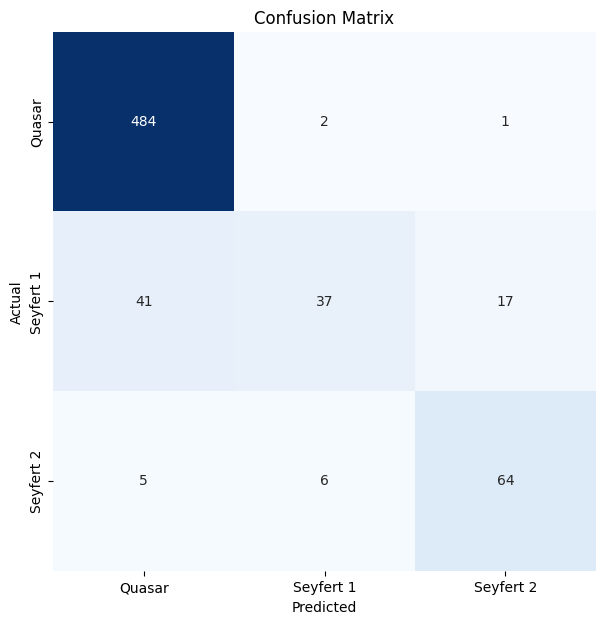

Total data set: 2628
Training set: 1971
Testing set: 657
Minimum accuracy: 84.32
Maximum accuracy: 89.04
Average accuracy: 87.33


In [ ]:
# This file will use the data set downloaded and run a kNN algorithm over it then use metrics for evaluation
# Data set will be split into training, cross-validation, and testing sets

from sklearn import neighbors
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import pandas as ps
import numpy as np

def main():
    data_df = ps.read_csv("training.txt")
    print(data_df.shape)
    # Creating x & y sets from data to be split into training sets
    data_df.dropna(how="any", inplace=True)
    x = data_df.iloc[:, :-1].values
    y = data_df.iloc[:, -1].values
    print(x.shape)
    print(y.shape)
    min_acc = 100
    avg = 0
    max_acc = 0
    test_cases = 50

    # Running many instances of machine learning
    for i in range(test_cases):
        # Building train/test split
        x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=int((np.random.default_rng().random() * 100)) + 1)

        # Creating and fitting kNN
        algo = neighbors.KNeighborsClassifier(n_neighbors=10, weights="distance")
        algo.fit(x_train, y_train)
        y_hat = algo.predict(x_test)
        cm = confusion_matrix(y_test, y_hat)


        # Calculating accuracy metric and comparing to current data
        accuracy = accuracy_score(y_test, y_hat) * 100
        avg += accuracy
        if accuracy < min_acc:
            min_acc = accuracy

        if accuracy > max_acc:
            class_names = ["Quasar", "Seyfert 1", "Seyfert 2"]
            plot_confusion_matrix(cm, class_names)
            max_acc = accuracy

    avg /= test_cases
    print("Total data set: %d" % len(y))
    print("Training set: %d" % len(y_train))
    print("Testing set: %d" % len(y_test))
    print("Minimum accuracy: %.2f" % min_acc)
    print("Maximum accuracy: %.2f" % max_acc)
    print("Average accuracy: %.2f" % avg)

main()

In [ ]:
import pandas as pd
import numpy as np
data_df = pd.read_csv("training.txt")
print(data_df.describe())

                 1            2            3            4            5  \
count  2628.000000  2628.000000  2628.000000  2628.000000  2628.000000   
mean      6.971709     6.937721     6.933638     6.928219     6.941591   
std      12.304239    12.260078    12.113299    12.117789    12.296001   
min      -2.950000    -2.410000    -5.600000    -6.030000    -5.910000   
25%       2.010000     2.007500     2.007500     1.980000     2.007500   
50%       3.700000     3.675000     3.690000     3.690000     3.630000   
75%       7.530000     7.487500     7.502500     7.545000     7.395000   
max     328.970001   321.920013   311.059998   315.369995   329.600006   

                 6            7            8            9           10  ...  \
count  2628.000000  2628.000000  2628.000000  2628.000000  2628.000000  ...   
mean      6.966591     6.963314     6.946617     6.899642     6.973999  ...   
std      12.382561    12.250800    12.177224    12.221824    12.296617  ...   
min      -7.38000

Epoch 1/100
53/53 [==============================] - 4s 24ms/step - loss: 0.8771 - accuracy: 0.8721 - val_loss: 0.3212 - val_accuracy: 0.9121
Epoch 2/100
53/53 [==============================] - 1s 15ms/step - loss: 0.5887 - accuracy: 0.8882 - val_loss: 0.3241 - val_accuracy: 0.9074
Epoch 3/100
53/53 [==============================] - 1s 13ms/step - loss: 0.3972 - accuracy: 0.9084 - val_loss: 0.4512 - val_accuracy: 0.9074
Epoch 4/100
53/53 [==============================] - 1s 14ms/step - loss: 0.3501 - accuracy: 0.9102 - val_loss: 0.8055 - val_accuracy: 0.8884
Epoch 5/100
53/53 [==============================] - 0s 8ms/step - loss: 0.4746 - accuracy: 0.9001 - val_loss: 0.3197 - val_accuracy: 0.9097
Epoch 6/100
53/53 [==============================] - 0s 5ms/step - loss: 0.2938 - accuracy: 0.9143 - val_loss: 0.2499 - val_accuracy: 0.9145
Epoch 7/100
53/53 [==============================] - 1s 11ms/step - loss: 0.3919 - accuracy: 0.9197 - val_loss: 0.2584 - val_accuracy: 0.9216
Epoch 8/

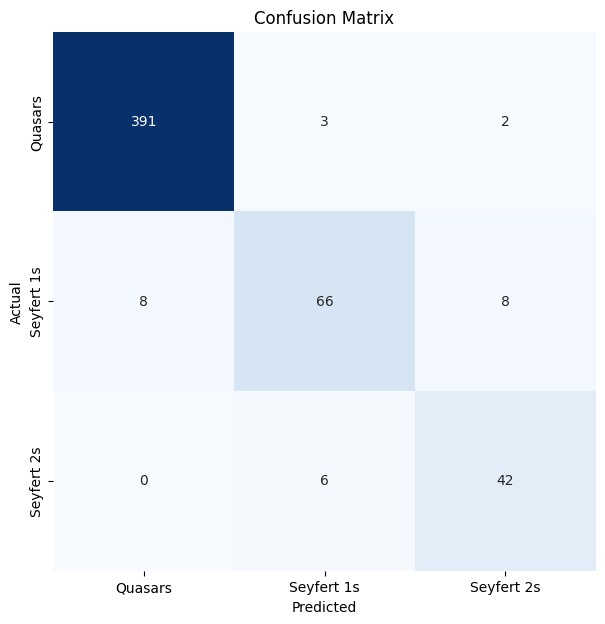

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.callbacks import EarlyStopping
import pandas as pd
import numpy as np

def plot_confusion_matrix(cm, classes):
    """Plots a confusion matrix."""
    fig, ax = plt.subplots(figsize=(7,7))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False,
                xticklabels=classes, yticklabels=classes)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show()

def main():
    # Load and prepare data
    data_df = pd.read_csv("training.txt")
    data_df.dropna(how="any", inplace=True)
    x = data_df.iloc[:, :-1].values
    y = data_df.iloc[:, -1].values

    # Convert class names to integer values
    mapping = {'Quasar': 0, 'Seyfert 1': 1, 'Seyfert 2': 2}
    y = np.vectorize(mapping.get)(y)

    # One-hot encode the labels
    y_onehot = tf.keras.utils.to_categorical(y, num_classes=3)

    # Normalize the features
    scaler = StandardScaler()
    x = scaler.fit_transform(x)

    # Split the dataset
    x_train, x_test, y_train, y_test = train_test_split(x, y_onehot, test_size=0.2)

    # Build the neural network model
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(128, activation='relu', input_shape=(x_train.shape[1],)),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(3, activation='softmax')  # 3 neurons for 3 classes
    ])

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    early_stopping = EarlyStopping(monitor='val_accuracy', patience=30, restore_best_weights=True)
    # Train the model
    model.fit(x_train, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

    # Predict using the model
    y_pred = model.predict(x_test)
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Evaluate the model's performance
    accuracy = accuracy_score(np.argmax(y_test, axis=1), y_pred_classes) * 100
    print(f"Neural Network Accuracy: {accuracy:.2f}%")

    # Display confusion matrix
    cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred_classes)
    class_names = ['Quasars', 'Seyfert 1s', 'Seyfert 2s']
    plot_confusion_matrix(cm, class_names)
    model.save("classifier_95_percent_acc.h5")

main()